## Setup

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import isuelogit as isl
import glob

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

isl.config.dirs['read_network_data'] = "input/network-data/fresno/"

main dir: /Users/pablo/github/gisuelogit


In [3]:
# Internal modules
from src.gisuelogit.visualizations import plot_predictive_performance, plot_convergence_estimates
from src.gisuelogit.etl import data_curation, add_period_id

## Read spatiotemporal data

In [4]:
folderpath = isl.config.dirs['read_network_data'] + 'links/spatiotemporal-data/'
df = pd.concat([pd.read_csv(file) for file in glob.glob(folderpath + "*link-data*")], axis=0)

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[df['date'].dt.dayofweek.between(0, 3)]
# df = df[df['date'].dt.year == 2019]

df['period'] = df['date'].astype(str) + '-' + df['hour'].astype(str)
df['period'] = df.period.map(hash)

In [5]:
# Add period id for timevarying estimation

period_feature = 'hour'

df['period'] = df['date'].astype(str) + '-' + df[period_feature].astype(str)
# df['period'] = df.period.map(hash)

df = add_period_id(df, period_feature='hour')

period_keys = df[[period_feature,'period_id']].drop_duplicates().reset_index().drop('index',axis =1).sort_values('hour')
print(period_keys)

    hour  period_id
11     6          0
12     7          1
13     8          2
14     9          3
0     10          4
1     11          5
2     12          6
3     13          7
4     14          8
5     15          9
6     16         10
7     17         11
8     18         12
9     19         13
10    20         14


## Data curation

In [6]:
df['tt_ff'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_ref_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_ref_avg == 0),'tt_ff'] = float('nan')

df['tt_avg'] = np.where(df['link_type'] != 'LWRLK', 0,df['length']/df['speed_hist_avg'])
df.loc[(df.link_type == "LWRLK") & (df.speed_hist_avg == 0),'tt_avg'] = float('nan')

df = data_curation(df)

In [7]:
df[['speed_ref_avg','speed_hist_avg', 'tt_ff', 'tt_avg']].describe()

,speed_ref_avg,speed_hist_avg,tt_ff,tt_avg
count,1.013460e+06,1.009583e+06,1.013460e+06,887813.000000
mean,1.924470e+01,1.767589e+01,3.397371e-03,0.003658
std,1.982261e+01,1.909664e+01,4.350074e-03,0.004367
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
50%,2.112700e+01,1.755400e+01,2.495627e-03,0.002784
75%,2.796200e+01,2.547600e+01,4.653995e-03,0.005216
max,6.772900e+01,7.891400e+01,7.034335e-02,0.063791


## Data processing

In [8]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['year'] = df.date.dt.year

In [9]:
df.query('year == 2019')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,31624.000000,542925.000000,468303.000000,542925.000000,542925.000000
mean,1761.140959,0.003415,0.003699,0.200169,17.946237
std,770.228931,0.004370,0.004448,0.228208,20.262676
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1249.000000,0.000000,0.000000,0.000000,0.000000
50%,1686.000000,0.002508,0.002814,0.152000,16.000000
75%,2162.450000,0.004702,0.005304,0.280000,27.340000
max,4807.000000,0.070343,0.063791,2.302000,75.652000


In [10]:
df.query('year == 2020')[['counts', 'tt_ff', 'tt_avg', 'tf_inrix', 'speed_avg']].describe()

,counts,tt_ff,tt_avg,tf_inrix,speed_avg
count,27472.000000,470535.000000,419510.000000,470535.000000,470535.000000
mean,1605.127777,0.003377,0.003613,0.198494,19.650807
std,743.713869,0.004326,0.004275,0.226003,20.229134
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,1108.450000,0.000000,0.000000,0.000000,0.000000
50%,1528.900000,0.002491,0.002756,0.150000,20.505000
75%,1978.000000,0.004578,0.005112,0.273000,28.117000
max,4766.000000,0.070343,0.054574,2.113000,73.943000


In [11]:
print(1-1793.271103/1865.514775, 1-17.469430/18.895705)


0.03872586428590474 0.07548143877140334


## EDA

### Observations

In [12]:
# Single period models
df.loc[(df.hour == 16) & (df.year == 2019),['counts', 'tt_avg']].describe()

,counts,tt_avg
count,2105.000000,31314.000000
mean,2191.828076,0.003848
std,821.116423,0.004593
min,3.000000,0.000000
25%,1690.000000,0.000000
50%,2082.400000,0.002906
75%,2674.000000,0.005654
max,4807.000000,0.057115


In [13]:
# TVODLULPE
df.loc[(df.hour.isin([6,7,8,15,16,17])) & (df.year == 2019),['counts', 'tt_avg']].describe()

,counts,tt_avg
count,12647.000000,186612.000000
mean,2002.699526,0.003580
std,763.098271,0.004315
min,2.000000,0.000000
25%,1519.300000,0.000000
50%,1920.000000,0.002716
75%,2410.000000,0.005113
max,4807.000000,0.057115


### Link attributes

In [57]:
features_Z = ['tt_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

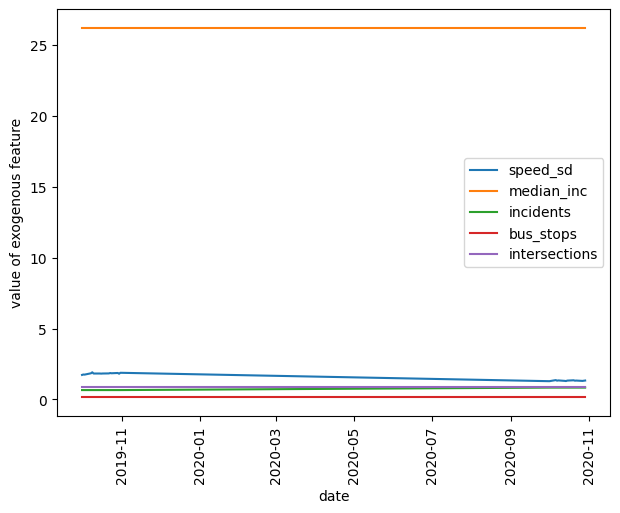

In [58]:
features_plot = ['speed_sd', 'median_inc', 'incidents', 'bus_stops', 'intersections']

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(df.groupby('date')[features_plot].mean().reset_index(),id_vars= ['date']))
plt.tight_layout()
plt.legend(title="")
plt.ylabel("value of exogenous feature")
plt.xticks(rotation=90)
plt.show()

## Analyze single file of inrix data

In [15]:
inrix_df = pd.read_csv(f"{os.getcwd()}/input/private/inrix/2020-10-01.csv")
inrix_df['ts'] = pd.to_datetime(inrix_df['UTC Date Time'])
inrix_df['hour'] = inrix_df.ts.dt.hour
inrix_df['speed'] = inrix_df['Speed(km/hour)']*0.62137119223

In [16]:
# Select data from same time range
inrix_df = inrix_df[inrix_df.hour.isin(range(4,23))]

In [17]:
inrix_df.head()

,Date Time,Segment ID,UTC Date Time,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,Road Closure,Corridor/Region Name,ts,hour,speed
4,2020-10-01,1626763236,2020-10-01 04:00:00,52.0,48.0,42.0,0.13,90.0,100.0,0.0,0.0,F,Fresno_CA,2020-10-01 04:00:00,4,32.311302
5,2020-10-01,1626763236,2020-10-01 04:15:00,51.0,47.0,42.0,0.15,90.0,53.0,47.0,0.0,F,Fresno_CA,2020-10-01 04:15:00,4,31.689931
6,2020-10-01,1626763236,2020-10-01 04:30:00,47.0,47.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:30:00,4,29.204446
7,2020-10-01,1626763236,2020-10-01 04:45:00,45.0,45.0,42.0,0.17,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 04:45:00,4,27.961704
8,2020-10-01,1626763236,2020-10-01 05:00:00,48.0,48.0,42.0,0.15,NaN,0.0,100.0,0.0,F,Fresno_CA,2020-10-01 05:00:00,5,29.825817


In [18]:
inrix_df.describe()

,Segment ID,Speed(km/hour),Hist Av Speed(km/hour),Ref Speed(km/hour),Travel Time(Minutes),CValue,Pct Score30,Pct Score20,Pct Score10,hour,speed
count,1.020604e+06,1.020300e+06,940434.000000,1.020604e+06,1.020300e+06,705930.000000,1.020300e+06,1.020300e+06,1.020300e+06,1.020604e+06,1.020300e+06
mean,7.942554e+08,5.513983e+01,54.284333,5.593239e+01,4.545113e-01,95.063257,6.403537e+01,2.810540e+01,7.859205e+00,1.300000e+01,3.426230e+01
std,6.271538e+08,2.324176e+01,23.336311,2.250260e+01,4.023858e-01,5.040026,4.606894e+01,4.291665e+01,2.655070e+01,5.477228e+00,1.444176e+01
min,1.684284e+08,6.000000e+00,6.000000,1.000000e+01,0.000000e+00,50.000000,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,3.728227e+00
25%,3.999621e+08,3.900000e+01,37.000000,4.000000e+01,1.300000e-01,90.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.000000e+00,2.423348e+01
50%,4.416791e+08,4.900000e+01,48.000000,5.000000e+01,3.500000e-01,96.670000,1.000000e+02,0.000000e+00,0.000000e+00,1.300000e+01,3.044719e+01
75%,1.626652e+09,7.100000e+01,71.000000,7.100000e+01,6.700000e-01,100.000000,1.000000e+02,8.000000e+01,0.000000e+00,1.800000e+01,4.411735e+01
max,1.626775e+09,1.220000e+02,122.000000,1.140000e+02,8.170000e+00,100.000000,1.000000e+02,1.000000e+02,1.000000e+02,2.200000e+01,7.580729e+01


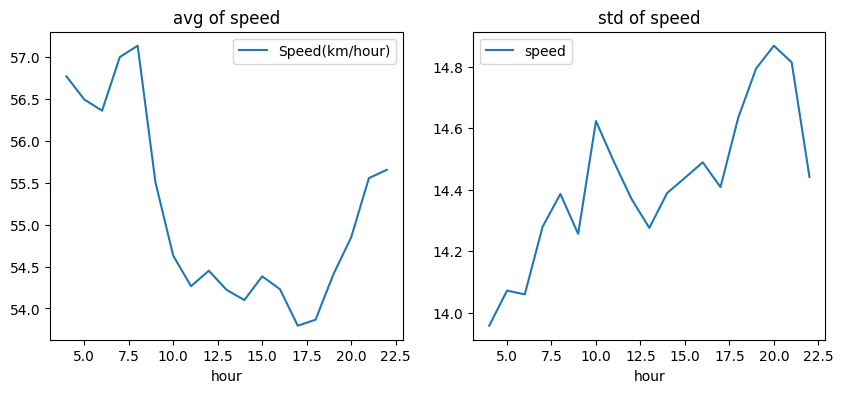

In [19]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df.groupby('hour')[['Speed(km/hour)']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df.groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

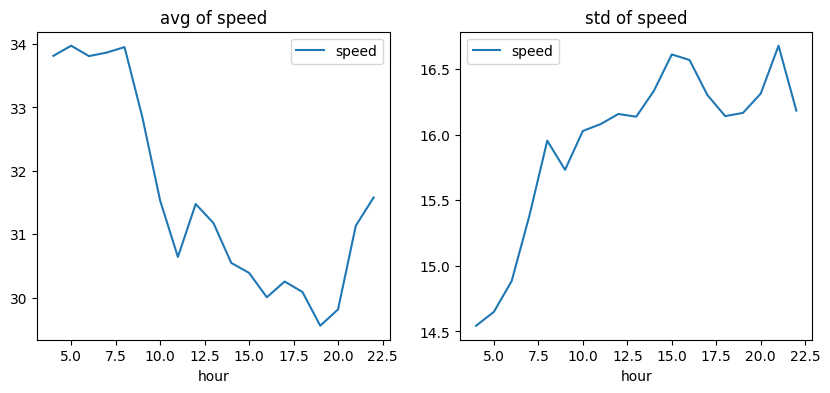

In [20]:
# Filter only data from inrix segments that were matched with the network links

fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].mean(),
             ax = axs[0])
axs[0].set_title('avg of speed')

sns.lineplot(data = inrix_df[inrix_df['Segment ID'].isin(list(df.inrix_id.dropna().unique()))].groupby('hour')[['speed']].std(),
             ax = axs[1])
axs[1].set_title('std of speed');

## Stats by date

In [21]:
# To check that there is a balanced amount of observations per date
obs_date = df.groupby('date')['hour'].count()

In [22]:
# Stats by date
df.groupby('date')[['speed_sd','speed_avg', 'counts']].mean().assign(total_obs = obs_date)

,speed_sd,speed_avg,counts,total_obs
date,,,,
2019-10-01,1.731787,17.175187,1770.335035,36195
2019-10-02,1.760109,17.169768,1746.651824,36195
2019-10-03,1.754288,17.092304,1785.115209,36195
2019-10-08,1.847060,18.165569,1747.732955,36195
2019-10-09,1.917923,18.137042,1756.834846,36195
2019-10-10,1.830232,18.107925,1793.512340,36195
2019-10-15,1.831527,18.114384,1750.339155,36195
2019-10-16,1.823680,18.162625,1760.170975,36195
2019-10-17,1.832219,18.080860,1775.411385,36195


### Cross sectional

In [23]:
# eda_df = df[df.year == 2019].copy()
eda_df = df.copy()
eda_df['date'] = eda_df['date'].astype(str)

# Transform to monthly income
eda_df['median_inc'] = eda_df['median_inc']/12

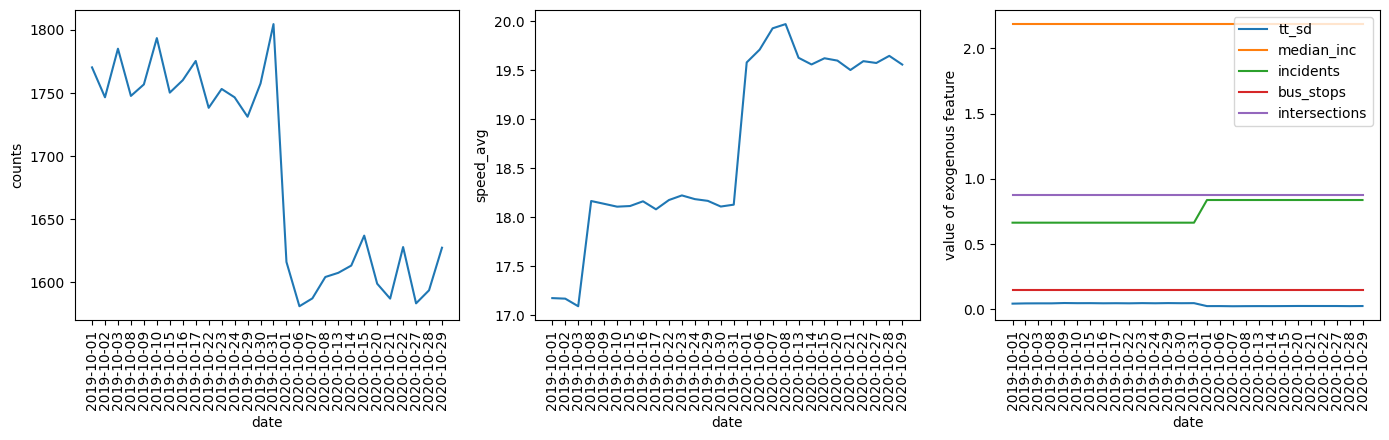

In [55]:
fig, axs = plt.subplots(1,3, figsize = (14,4.5))

sns.lineplot(x= 'date', y = 'counts', data =eda_df.groupby('date')[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'date', y = 'speed_avg', data =eda_df.groupby('date')[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'date', y = 'value', hue = 'variable', data =pd.melt(eda_df.groupby('date')[features_plot].mean().reset_index(),id_vars= ['date']),
             ax = axs[2])

axs[2].legend(title="", loc = 'upper right')
axs[2].set_ylabel("value of exogenous feature")

#list(map(lambda x: x.set_xticklabels(x.get_xticks(), rotation=90), axs));
fig.autofmt_xdate(rotation = 90, ha = 'center')
fig.tight_layout()

### By hour of day

In [25]:
link_keys = eda_df[(eda_df.counts>0) & (eda_df.speed_avg>0)].link_key.unique()
link_keys = link_keys[0:10]

<AxesSubplot: xlabel='hour', ylabel='speed_avg'>

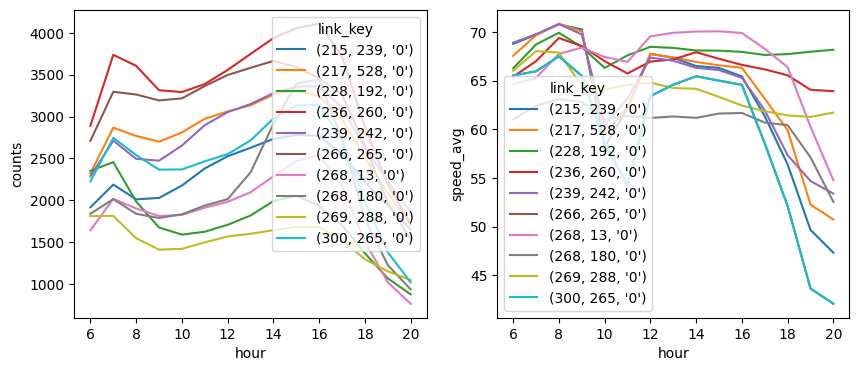

In [26]:
fig, axs = plt.subplots(1,2, figsize = (10,4))

sns.lineplot(x= 'hour', y = 'counts', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg', hue = 'link_key',
             data =eda_df[eda_df.link_key.isin(link_keys)].groupby(['hour','link_key'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

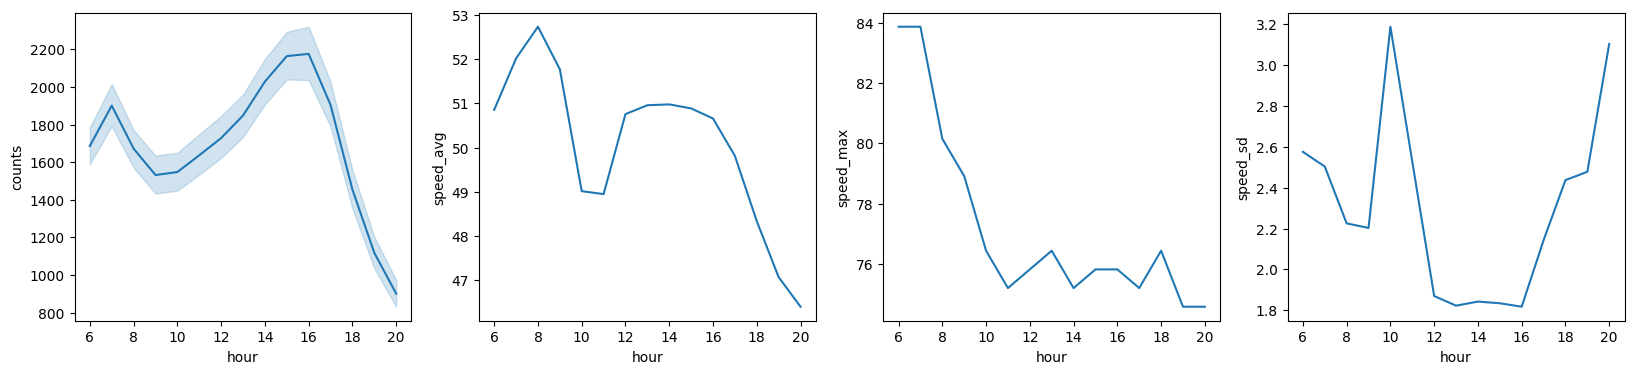

In [28]:
# Analysis for links where link counts are reported

fig, axs = plt.subplots(1,4, figsize = (20,4))

sns.lineplot(x= 'hour', y = 'counts', data =eda_df.groupby(['hour','link_key'])[['counts']].mean().reset_index(),
             ax = axs[0])

sns.lineplot(x= 'hour', y = 'speed_avg',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_avg']].mean().reset_index(),
             ax = axs[1])

sns.lineplot(x= 'hour', y = 'speed_max',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_max']].max().reset_index(),
             ax = axs[2])

sns.lineplot(x= 'hour', y = 'speed_sd',
             data =eda_df[~eda_df.counts.isna()].groupby(['hour'])[['speed_sd']].mean().reset_index(),
             ax = axs[3])

plt.show()

## Read models results

In [25]:
ts = 230211161720
train_results_dfs = pd.read_csv(f'output/tables/{ts}_train_results_Fresno.csv', index_col = [0])
test_results_dfs = pd.read_csv(f'output/tables/{ts}_train_results_Fresno.csv', index_col = [0])

## Configuration

In [26]:
_XTICKS_SPACING = 50

In [28]:
 train_results_dfs

,model,loss_tt,loss_od,loss_theta,loss_flow,loss_eq_flow,loss_eq_tt,loss_bpr,loss_ntrips,loss_prop_od,...,median_inc,incidents,bus_stops,intersections,alpha,beta,psc_factor,fixed_effect,relative_gap,stage
0,lue,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,1.000000e+00,...,0.0,0.000000,0.0,0.000000,0.15000,4.0,0.0,0.000000,1.000000e-06,learning
1,lue,0.906859,1.000000,NaN,0.940350,1.000000,NaN,0.906859,NaN,1.000000e+00,...,0.0,-0.499987,0.0,-0.499980,0.15000,4.0,0.0,0.000000,2.031706e+01,learning
2,lue,0.821353,1.000000,NaN,0.883513,0.987792,NaN,0.821353,NaN,1.000000e+00,...,0.0,-0.797271,0.0,-0.825532,0.15000,4.0,0.0,0.000000,5.746030e-01,learning
3,lue,0.744007,1.000000,NaN,0.829400,0.945974,NaN,0.744007,NaN,1.000000e+00,...,0.0,-1.015035,0.0,-1.077129,0.15000,4.0,0.0,0.000000,2.733642e-01,learning
4,lue,0.674406,1.000000,NaN,0.778085,0.897170,NaN,0.674406,NaN,1.000000e+00,...,0.0,-1.186916,0.0,-1.284343,0.15000,4.0,0.0,0.000000,1.726049e-01,learning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,tvodlulpe,0.015239,675.379702,NaN,0.179963,0.000040,NaN,0.015239,0.147664,2.997506e+31,...,0.0,0.000000,0.0,-1.253441,0.82053,4.0,0.0,-0.152375,1.456427e-06,equilibrium
175,tvodlulpe,0.015248,675.379702,NaN,0.180010,0.000029,NaN,0.015248,0.147664,2.997506e+31,...,0.0,0.000000,0.0,-1.253441,0.82053,4.0,0.0,-0.152375,1.803049e-06,equilibrium
176,tvodlulpe,0.015260,675.379702,NaN,0.179959,0.000029,NaN,0.015260,0.147664,2.997506e+31,...,0.0,0.000000,0.0,-1.253441,0.82053,4.0,0.0,-0.152375,1.392260e-06,equilibrium
177,tvodlulpe,0.015246,675.379702,NaN,0.179942,0.000024,NaN,0.015246,0.147664,2.997506e+31,...,0.0,0.000000,0.0,-1.253441,0.82053,4.0,0.0,-0.152375,1.071501e-06,equilibrium


### Model 1: Estimation of utility function (LUE)


LUE: Estimation of utility function


/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_1800/4186502861.py:8: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.DataFrame({'fixed_effect':np.array(train_results_dfs[train_results_dfs.model == 'lue']['fixed_effect'])}),


alpha =  0.15, beta  =  4.00


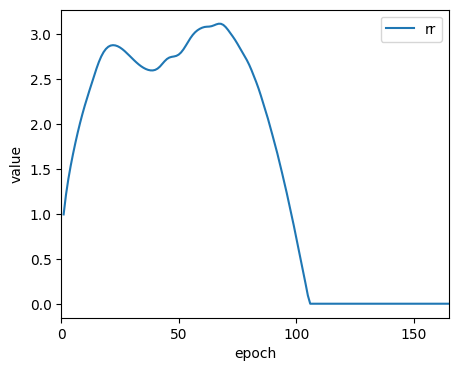

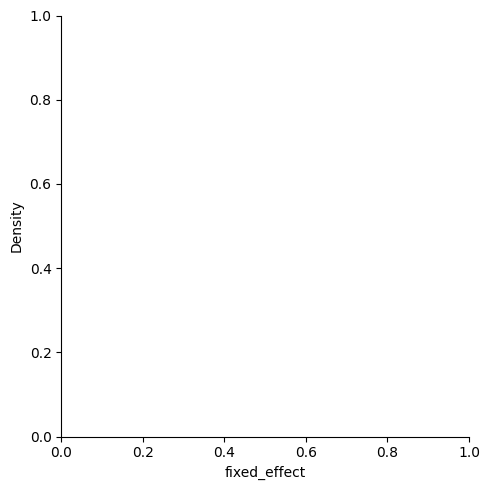

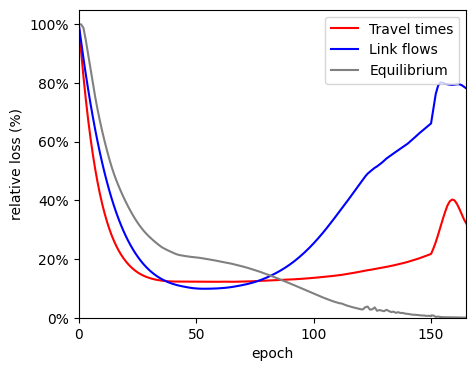

In [32]:
print('\nLUE: Estimation of utility function')

# Average reliability ratio over epochs
plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'lue'].\
                   assign(rr = train_results_dfs[train_results_dfs.model == 'lue']['tt_sd']/train_results_dfs[train_results_dfs.model == 'lue']['tt'])[['epoch','rr']],
                       xticks_spacing = _XTICKS_SPACING)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'lue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'lue'],
                            xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(lue.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'lue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'lue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 2: OD + utility estimation with historic OD (ODLUE)


ODLUE: OD + utility estimation with historic OD


/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_1800/3781557863.py:16: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.displot(pd.DataFrame({'fixed_effect':train_results_dfs[train_results_dfs.model == 'odlue']['fixed_effect']}),


alpha =  0.15, beta  =  4.00


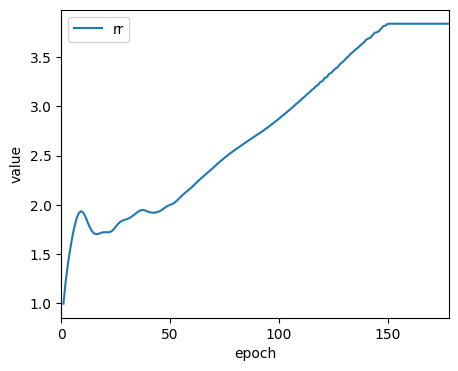

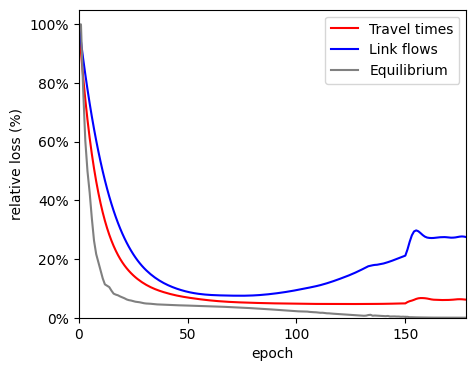

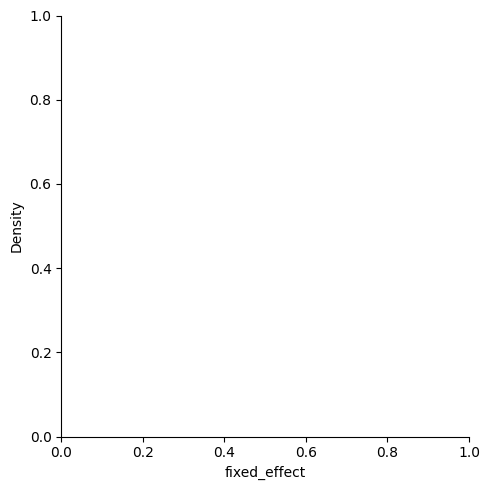

In [34]:
print('\nODLUE: OD + utility estimation with historic OD')

train_results_dfs.loc[train_results_dfs.model == 'odlue','model'] = 'odlue'
test_results_dfs.loc[test_results_dfs.model == 'odlue','model'] = 'odlue'

# Average reliability ratio over epochs
plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlue'].\
                   assign(rr = train_results_dfs[train_results_dfs.model == 'odlue']['tt_sd']/train_results_dfs[train_results_dfs.model == 'odlue']['tt'])[['epoch','rr']],
                       xticks_spacing = _XTICKS_SPACING)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlue'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlue'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)


# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlue_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlue']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlue']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 3: ODLUE + link specific performance parameters (ODLULPE)


ODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)
alpha =  0.79, beta  =  4.00


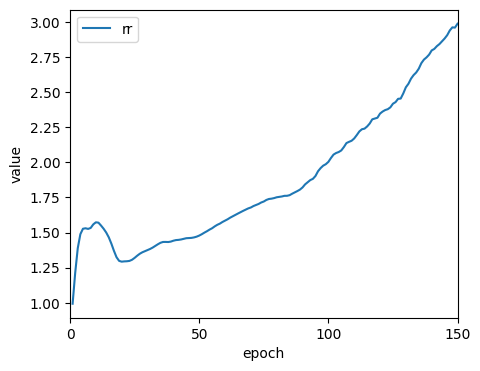

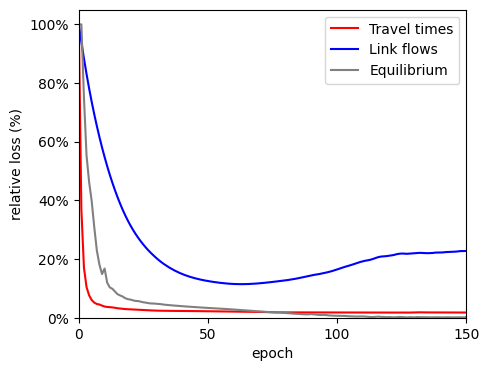

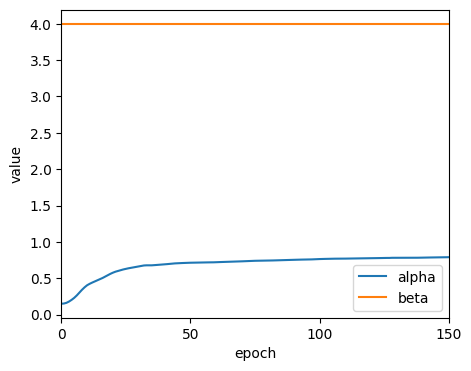

In [97]:
print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix (link specifics alphas and betas)')

train_results_dfs.loc[train_results_dfs.model == 'odlulpe','model'] = 'odlulpe'
test_results_dfs.loc[test_results_dfs.model == 'odlulpe','model'] = 'odlulpe'

# Average reliability ratio over epochs
plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'odlulpe'].\
                   assign(rr = train_results_dfs[train_results_dfs.model == 'odlulpe']['tt_sd']/train_results_dfs[train_results_dfs.model == 'odlulpe']['tt'])[['epoch','rr']],
                       xticks_spacing = _XTICKS_SPACING)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'odlulpe'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'odlulpe'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'odlulpe'][['epoch','alpha','beta']],
    xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(odlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'odlulpe']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'odlulpe']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

### Model 4: ODLULPE with Time Varying OD and Utility Function (TVODLULPE)


tvodlulpe: Time specific utility and OD, link performance parameters
alpha =  0.82, beta  =  4.00


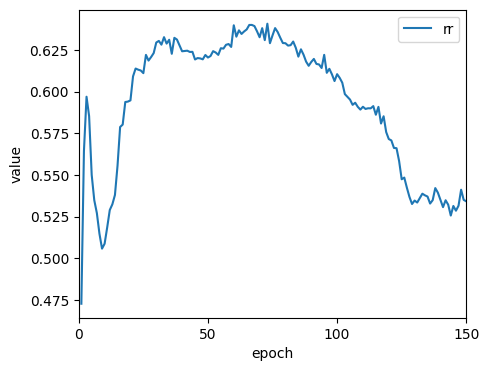

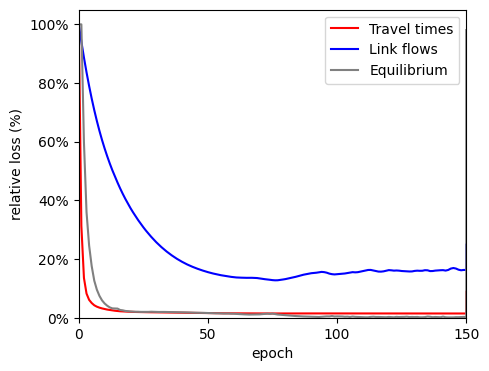

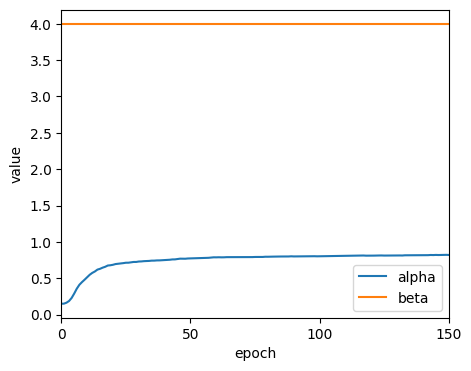

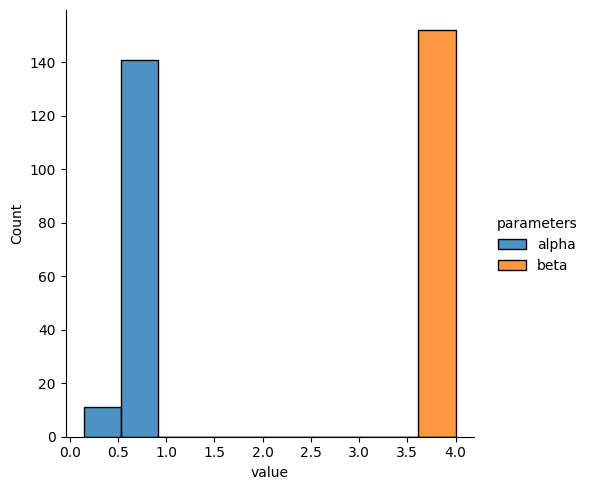

In [98]:
print('\ntvodlulpe: Time specific utility and OD, link performance parameters')

train_results_dfs.loc[train_results_dfs.model == 'tvodlulpe','model'] = 'tvodlulpe'
test_results_dfs.loc[test_results_dfs.model == 'tvodlulpe','model'] = 'tvodlulpe'

# Average reliability ratio over epochs
plot_convergence_estimates(estimates=train_results_dfs[train_results_dfs.model == 'tvodlulpe'].\
                   assign(rr = train_results_dfs[train_results_dfs.model == 'tvodlulpe']['tt_sd']/train_results_dfs[train_results_dfs.model == 'tvodlulpe']['tt'])[['epoch','rr']],
                       xticks_spacing = _XTICKS_SPACING)

plot_predictive_performance(train_losses=train_results_dfs[train_results_dfs.model == 'tvodlulpe'],
                            val_losses=test_results_dfs[test_results_dfs.model == 'tvodlulpe'],
                            show_validation= False,
                            xticks_spacing = _XTICKS_SPACING)

plot_convergence_estimates(
    estimates=train_results_dfs[train_results_dfs.model == 'tvodlulpe'][['epoch','alpha','beta']],
    xticks_spacing = _XTICKS_SPACING)

# print(f"theta = {dict(zip(utility_parameters.true_values.keys(), list(tvodlulpe_1.theta.numpy())))}")
print(f"alpha = {list(train_results_dfs[train_results_dfs.model == 'tvodlulpe']['alpha'])[-1]: 0.2f}, "
      f"beta  = {list(train_results_dfs[train_results_dfs.model == 'tvodlulpe']['beta'])[-1]: 0.2f}")
# print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(tvodlulpe_1.q - fresno_network.q.flatten())): 0.2f}")
# print(f"Avg observed OD: {np.mean(np.abs(fresno_network.q.flatten())): 0.2f}")

## Summary of parameters estimates

In [88]:
_EPOCHS = {'learning': 150, 'equilibrium': 50}

In [89]:
# train_results_dfs = train_results_dfs[train_results_dfs['epoch'] <= _EPOCHS['learning']]

In [90]:
train_results_dfs

,model,loss_tt,loss_od,loss_theta,loss_flow,loss_eq_flow,loss_eq_tt,loss_bpr,loss_ntrips,loss_prop_od,...,median_inc,incidents,bus_stops,intersections,alpha,beta,psc_factor,fixed_effect,relative_gap,stage
0,lue,1.000000,1.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,1.000000e+00,...,0.0,0.000000,0.0,0.000000,0.150000,4.0,0.0,0.000000,0.000001,learning
1,lue,0.906859,1.000000,NaN,0.940350,1.000000,NaN,0.906859,NaN,1.000000e+00,...,0.0,-0.499987,0.0,-0.499980,0.150000,4.0,0.0,0.000000,20.317063,learning
2,lue,0.821353,1.000000,NaN,0.883513,0.987792,NaN,0.821353,NaN,1.000000e+00,...,0.0,-0.797271,0.0,-0.825532,0.150000,4.0,0.0,0.000000,0.574603,learning
3,lue,0.744007,1.000000,NaN,0.829400,0.945974,NaN,0.744007,NaN,1.000000e+00,...,0.0,-1.015035,0.0,-1.077129,0.150000,4.0,0.0,0.000000,0.273364,learning
4,lue,0.674406,1.000000,NaN,0.778085,0.897170,NaN,0.674406,NaN,1.000000e+00,...,0.0,-1.186916,0.0,-1.284343,0.150000,4.0,0.0,0.000000,0.172605,learning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,tvodlulpe,0.014408,670.180635,NaN,0.163701,0.001824,NaN,0.014408,0.150615,2.986895e+31,...,0.0,0.000000,0.0,-1.238323,0.820711,4.0,0.0,-0.150731,0.019839,learning
148,tvodlulpe,0.014378,669.941032,NaN,0.161718,0.002479,NaN,0.014378,0.132432,2.989717e+31,...,0.0,0.000000,0.0,-1.244228,0.821449,4.0,0.0,-0.151312,0.019013,learning
149,tvodlulpe,0.014434,671.679135,NaN,0.162868,0.002774,NaN,0.014434,0.147070,2.992217e+31,...,0.0,0.000000,0.0,-1.250893,0.822090,4.0,0.0,-0.152059,0.010074,learning
150,tvodlulpe,0.014413,675.379702,NaN,0.162695,0.002482,NaN,0.014413,0.147664,2.997506e+31,...,0.0,0.000000,0.0,-1.253441,0.820530,4.0,0.0,-0.152375,0.006641,learning


In [91]:
models = train_results_dfs.model.unique()

In [92]:
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results_model = train_results_dfs.loc[train_results_dfs.model == model].iloc[-1]
    results = results.append(pd.DataFrame(
        {'parameter': ['tt'] + features_Z +
                      ['fixed_effect_mean','fixed_effect_std',
                       'alpha_mean', 'alpha_std',
                       'beta_mean', 'beta_std',
                       # 'od_mean', 'od_std'
                       ],
         'values': list(results_model[['tt'] + features_Z]) +
                   [np.mean(results_model['fixed_effect']),np.std(results_model['fixed_effect']),
                    np.mean(results_model['alpha']),np.std(results_model['alpha']),
                    np.mean(results_model['beta']),np.std(results_model['beta']),
                    # np.mean(model.q),np.std(model.q)
                    ]
         }
    ).assign(model = model))

In [93]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

model,lue,odlue,odlulpe,tvodlulpe
parameter,,,,
tt,-3.4348,-3.0680,-2.5444,-0.9938
tt_sd,0.0000,-11.7881,-7.6004,-0.5308
median_inc,0.0000,0.0000,0.0000,0.0000
incidents,-0.8837,-2.5045,-2.8683,0.0000
bus_stops,0.0000,0.0000,0.0000,0.0000
intersections,-1.3411,-2.6660,-2.8938,-1.2534
fixed_effect_mean,0.0000,0.0000,0.0000,-0.1524
fixed_effect_std,0.0000,0.0000,0.0000,0.0000
alpha_mean,0.1500,0.1500,0.7899,0.8205


In [94]:
train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model] = train_results_dfs[train_results_dfs.model == model]

    train_estimates[model]['model'] = model

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
#estimates = estimates[estimates.epoch != 0]

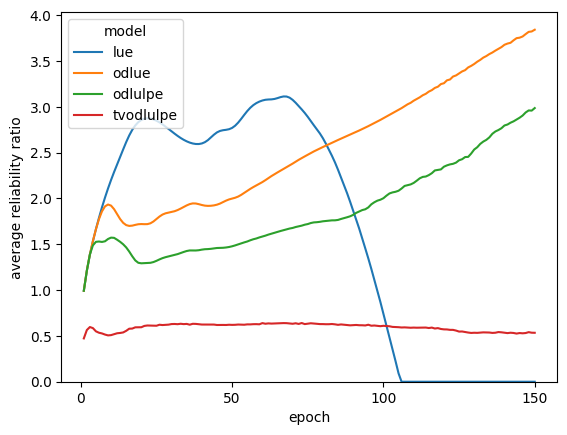

In [96]:
fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.set_ylabel('average reliability ratio')

plt.ylim(ymin=0)

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

plt.show()